### **Dependencies**

In [15]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import random

## **Load Data**

In [2]:
df = pd.read_csv("../../src/merged_orgas.csv")

In [3]:
df.columns

Index(['iati_id', 'iati_orga_id', 'orga_abbreviation', 'orga_full_name',
       'title_en', 'title_other', 'title_main', 'country_code_list', 'country',
       'country_name', 'country_flag', 'description_en', 'description_other',
       'description_main', 'status', 'crs_5_code', 'crs_5_name', 'crs_3_code',
       'crs_3_name', 'title_and_description', 'sgd_pred_code', 'sgd_pred_str',
       'client'],
      dtype='object')

In [4]:
df['crs_3_list'] = df['crs_3_code'].apply(
    lambda x: [element.strip() for element in x.split(';') if element.strip()] if pd.notna(x) else []
)
df['crs_3_list'].head()

0    [140]
1    [331]
2    [331]
3    [240]
4    [430]
Name: crs_3_list, dtype: object

In [5]:
df['crs_5_list'] = df['crs_5_code'].apply(
    lambda x: [element.strip() for element in x.split(';') if element.strip()] if pd.notna(x) else []
)
df['crs_5_list'].head()

0    [14010]
1    [33130]
2    [33130]
3    [24030]
4    [43010]
Name: crs_5_list, dtype: object

## **Load Models**

In [6]:
def calculate_bert_similarity(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**encoded_input)
    
    embeddings = outputs.last_hidden_state.mean(dim=1)
    similarity = cosine_similarity(embeddings[0:1].numpy(), embeddings[1:2].numpy()).item()

    return similarity


In [7]:
def calculate_tfidf_similarity(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    vectorizer = TfidfVectorizer()

    tfidf_matrix = vectorizer.fit_transform(sentences)
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2]).item()

    return similarity


In [8]:
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
def mini_lm(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    embeddings = minilm_model.encode(sentences, show_progress_bar=True)
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]]).item()
    return similarity


In [10]:
def mini_lm_extended(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    embeddings = minilm_model.encode(sentences, show_progress_bar=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()

    def is_match(set1, set2):
        return not set1.isdisjoint(set2)

    crs3_codes = filtered_df["crs_3_list"].tolist()
    if is_match(set(crs3_codes[0]), set(crs3_codes[1])):
        similarity += 0.025

    crs5_codes = filtered_df["crs_5_list"].tolist()
    if is_match(set(crs5_codes[0]), set(crs5_codes[1])):
        similarity += 0.05

    sdg_codes = filtered_df["sgd_pred_code"].tolist()
    if sdg_codes[0] == sdg_codes[1]:
        similarity += 0.05

    return similarity / 1.125

## **Evaluate Ground Truth Project matches**

### **Project Matches**

In [60]:
true_matches = [
    ["DE-1-201521939", "XM-DAC-46004-35183-013-LN2285"],
    ["DE-1-201923200", "44000-P177959"],
    ["DE-1-201722149", "44000-P127079"],
    ["DE-1-202221729", "44000-P170419"],
    ["DE-1-201822519", "44000-P176932"],
    ["DE-1-202120236", "44000-P151357"],
    ["DE-1-201822535", "44000-P172422"],
    ["DE-1-201822535", "44000-P169669"],
    ["DE-1-202322022", "44000-P124761"],
    ["DE-1-201923200", "44000-P166360"],
    ["DE-1-202120053", "44000-P085752"],
        ]

no_matches = [
    ["DE-1-201729375-0", "XM-DAC-5-7-6619182"],
    ["DE-1-201775048-0", "XI-IATI-IADB-CH-L1142"],
    ["XI-IATI-IADB-CH-L1142", "XM-DAC-46004-46059-002-LN3205"],
    ["DE-1-200967406", "46002-P-MW-KA0-002"],
    ["DE-1-200166744", "XM-DAC-918-3-20160661-88672"],
    ["DE-1-201901180-0", "44000-P112780"],
    ["DE-1-202070399", "44000-P112780"],
    ["DE-1-201606003-1475", "XM-DAC-918-3-20220488-94840"],
    ["DE-1-201336619", "44000-P167651"],
    ["DE-1-201568633", "44000-P159476"],
]

matches = true_matches + no_matches

results_bow = []
results_tfidf = []
results_minilm = []
results_minilm_ext = []

In [61]:
for i in matches:
    results_bow.append(
        calculate_bert_similarity(i)
    )
    results_tfidf.append(
        calculate_tfidf_similarity(i)
    )
    results_minilm.append(
        mini_lm(i)
    )
    results_minilm_ext.append(
        mini_lm_extended(i)
    )

results_all = [results_bow, results_tfidf, results_minilm, results_minilm_ext]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
len(no_matches)

10

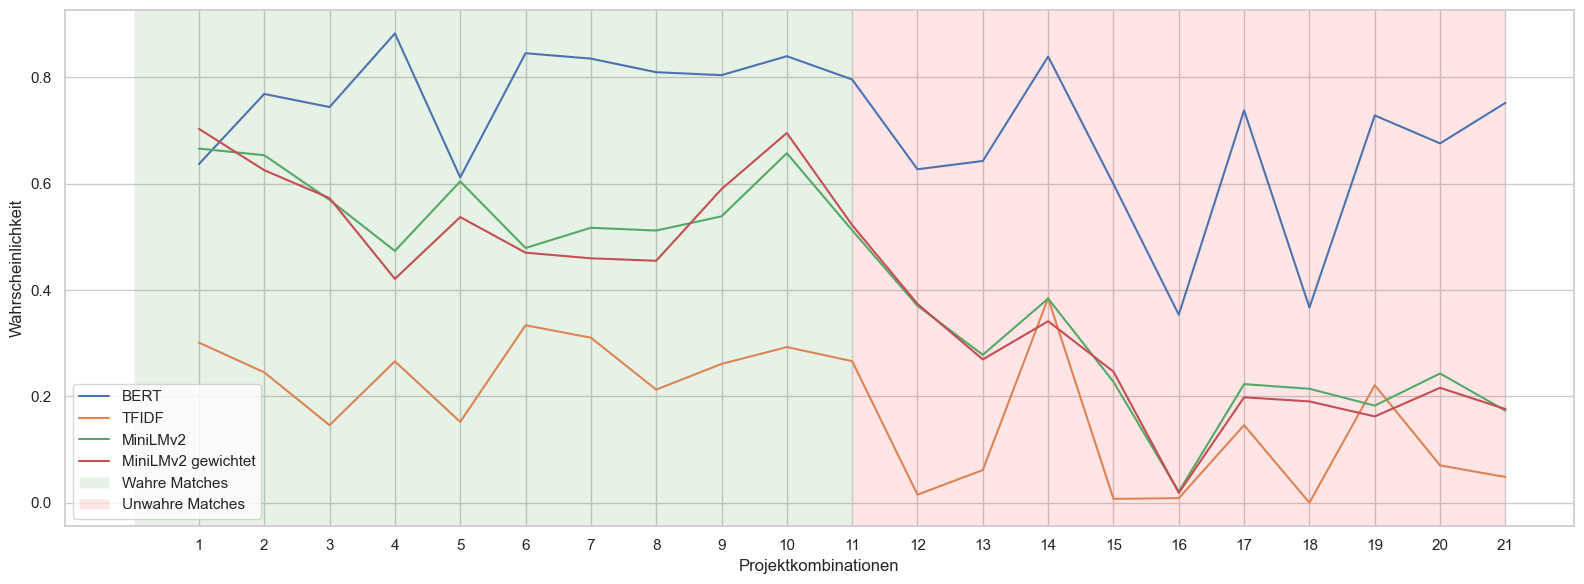

In [64]:
sns.set(style='whitegrid')

labels = ["BERT", "TFIDF", "MiniLMv2", "MiniLMv2 gewichtet"]

plt.figure(figsize=(16, 6))
x_values = range(1, len(results_all[0])+1)

for i, results in enumerate(results_all):
    plt.plot(x_values, results, label=labels[i])

#plt.title('Verschiedene Modelle zur Berechnung der Projektähnlichkeit')
plt.axvspan(0, len(true_matches), facecolor='green', alpha=0.1, label='Wahre Matches')
plt.axvspan(len(true_matches), len(matches), facecolor='red', alpha=0.1, label='Unwahre Matches')
plt.xlabel('Projektkombinationen')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(x_values) 
plt.legend()
plt.tight_layout()
plt.show()


## **Evaluate on random projects**

In [23]:
matches = []
for i in range(50):
    r1 = random.randint(0, len(df))
    r2 = random.randint(0, len(df))

    m = [df.iloc[r1]["iati_id"], df.iloc[r2]["iati_id"]]
    matches.append(m)


In [24]:
results_bow = []
results_tfidf = []
results_minilm = []
results_minilm_ext = []

for i in matches:
    results_bow.append(
        calculate_bert_similarity(i)
    )
    results_tfidf.append(
        calculate_tfidf_similarity(i)
    )
    results_minilm.append(
        mini_lm(i)
    )
    results_minilm_ext.append(
        mini_lm_extended(i)
    )

results_all = [results_bow, results_tfidf, results_minilm, results_minilm_ext]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

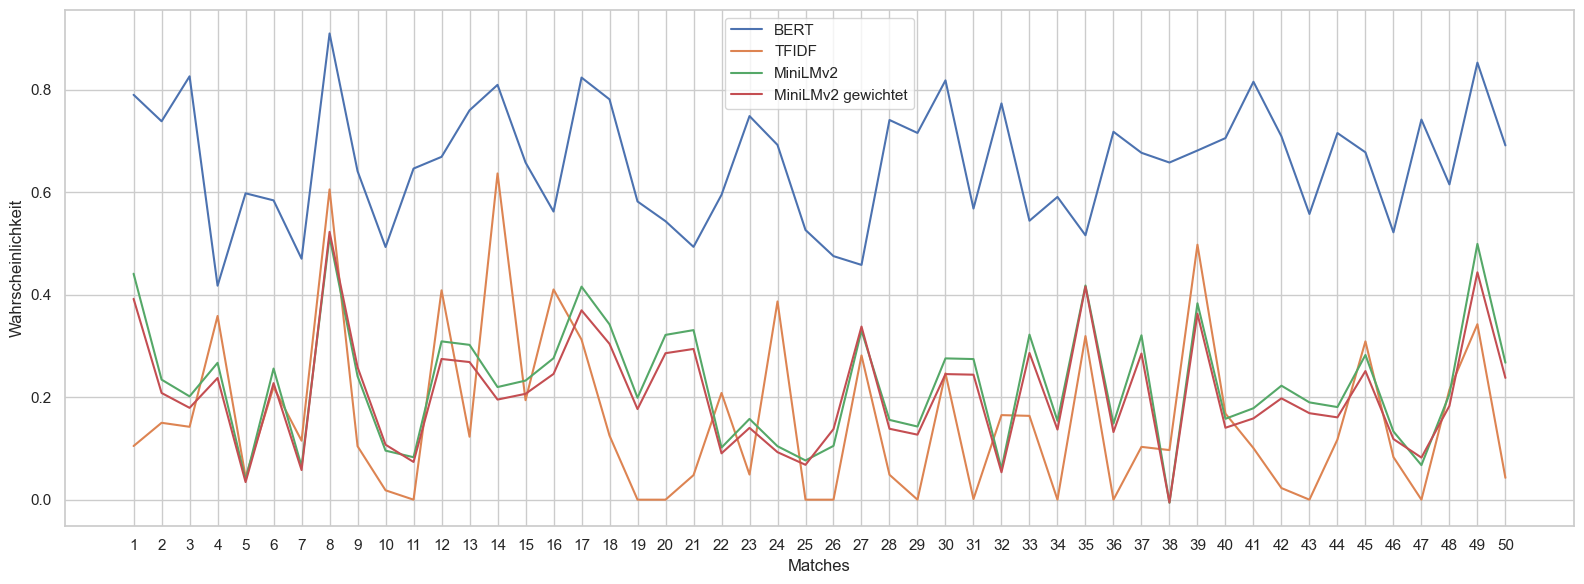

In [25]:
sns.set(style='whitegrid')

labels = ["BERT", "TFIDF", "MiniLMv2", "MiniLMv2 gewichtet"]

plt.figure(figsize=(16, 6))
x_values = range(1, len(results_all[0])+1)

for i, results in enumerate(results_all):
    plt.plot(x_values, results, label=labels[i])

#plt.title('Verschiedene Modelle zur Berechnung der Projektähnlichkeit')
plt.xlabel('Matches')
plt.ylabel('Wahrscheinlichkeit')
plt.xticks(x_values) 
plt.legend()
plt.tight_layout()
plt.show()